In [1]:
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import json
import scipy
import gurobipy as gp
from gurobipy import GRB
import gc
from time import time

# Data Independent Approach to Dataset Analysis

With new efficient truncation and coefficient computation methods based on marginal approximations, etc can setup new approach to dataset analysis:

- loop over samples and bootstrap, storing CI bounds and OB truncation
- for all OB counts compute and store OG truncation
- for all OB counts use OG truncation to compute and store coefficient grids
- then for any model can use stored info to construct optimization constraints

For now simply use dataset stored as csv file and capture efficiency as numpy array, but will later change functions to work with package dataset objects and store info.

# Example dataset

In [2]:
dataset = pd.read_csv("../Realistic-Data/Sampled-Capture-Data/Datasets/counts_easy_downsampled.csv", index_col=0)
beta = np.loadtxt("../Realistic-Data/Sampled-Capture-Data/Datasets/beta.csv")

# Bootstrap

### Bootstrap function

Takes in a sample and compute CI bounds and OB truncation information

### Bootstrap dataset

Given a dataset, loop over each sample and bootstrap, storing the CI bounds and OB truncations in named files

In [3]:
def bootstrap(sample, resamples=None, splits=1, thresh_OB=10, threshM_OB=10, plot=False, printing=False):
    '''
    Compute confidence intervals on the distribution of a sample of count pairs.

    Compute confidence intervals for the joint and marginal probabilities of the 
    sample using the percentile bootstrap and settings specified in the method
    object. Compute a state space truncation using a given threshold on the
    number of samples per interval, replacing intervals on probabilities of
    states outside the truncation by [0, 1] to improve coverage.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        method: instance of Hypothesis or Minimization class with settings
                stored as attributes

                .resamples: integer number of bootstrap resamples to use
                .splits: integer number of times to 'split' resampling across
                         multiple arrays to avoid memory issues
                .thresh_OB: threshold on observation frequency of a state pair
                            for state space truncation
                .threshM_OB: threshold on observation frequency on a state for
                             marginal state space truncation
        
        plot: toggle plotting of confidence intervals and estimates
        print: toggle printing of observed state space truncation

    Returns:
        A dictionary containing results

        Sample information:

        'sample': original sample used
        'sample_counts': occurances of each state pair in the original sample
        'sample_counts_x1': occurances of each state in the original sample (gene 1)
        'sample_counts_x2': occurances of each state in the original sample (gene 2)

        Confidence intervals:
    
        'joint': (2, _, _) numpy array of CI bounds on joint distribution
        'x1': (2, _) numpy array of CI bounds on marginal distribution (gene 1)
        'x2': (2, _) numpy array of CI bounds on marginal distribution (gene 2)

        Truncation information

        'min_x1_OB', 'max_x1_OB', 'min_x2_OB', 'max_x2_OB': joint truncation
        'minM_x1_OB', 'maxM_x1_OB': marginal truncation (gene 1)
        'minM_x2_OB', 'maxM_x2_OB': marginal truncation (gene 2)
        'thresh_flag': bool if joint state space was truncated
        'thresh_flag_x1': bool if marginal state space was truncated (gene 1)
        'thresh_flag_x2': bool if marginal state space was truncated (gene 2)
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    if type(sample[0]) == str:
        sample = [literal_eval(count_pair) for count_pair in sample]

    # compute maximum x1 and x2 values
    M, N = np.max(sample, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_sample = np.array([x[1] + (N + 1)*x[0] for x in sample], dtype='uint32')

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # number of bootstrap samples per split (split to reduce memory usage)
    resamples_split = resamples // splits

    # setup count array
    counts = np.empty((resamples, M + 1, N + 1), dtype='uint32')

    # BS bootstrap samples: split into 'splits' number of BS_split x n arrays
    for split in range(splits):

        # BS_split bootstrap samples as BS_split x n array
        bootstrap_split = rng.choice(integer_sample, size=(resamples_split, n))

        # offset row i by (D + 1)i
        bootstrap_split += np.arange(resamples_split, dtype='uint32')[:, None]*(D + 1)

        # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
        counts_split = np.bincount(bootstrap_split.ravel(), minlength=resamples_split*(D + 1)).reshape(-1, M + 1, N + 1)

        # add to counts
        counts[(split * resamples_split):((split + 1) * resamples_split), :, :] = counts_split

    # sum over columns / rows to give counts (/n) of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # scale to probability
    bounds = bounds / n
    x1_bounds = x1_bounds / n
    x2_bounds = x2_bounds / n

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_sample, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # set truncation bounds
    min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = M, 0, N, 0
    minM_x1_OB, maxM_x1_OB = M, 0
    minM_x2_OB, maxM_x2_OB = N, 0

    # set flag for changes
    thresh_flag = False
    thresh_flag_x1 = False
    thresh_flag_x2 = False

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh_OB:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < min_x1_OB:
                    min_x1_OB = x1
                    thresh_flag = True
                if x2 < min_x2_OB:
                    min_x2_OB = x2
                    thresh_flag = True
                # check if larger than current max
                if x1 > max_x1_OB:
                    max_x1_OB = x1
                    thresh_flag = True
                if x2 > max_x2_OB:
                    max_x2_OB = x2
                    thresh_flag = True

    for x1 in range(M + 1):
        # below: replace
        if x1_sample_counts[x1] < threshM_OB:
            x1_bounds[:, x1] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x1 < minM_x1_OB:
                minM_x1_OB = x1
                thresh_flag_x1 = True
            # check if larger than current max
            if x1 > maxM_x1_OB:
                maxM_x1_OB = x1
                thresh_flag_x1 = True

    for x2 in range(N + 1):
        # below: replace
        if x2_sample_counts[x2] < threshM_OB:
            x2_bounds[:, x2] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x2 < minM_x2_OB:
                minM_x2_OB = x2
                thresh_flag_x2 = True
            # check if larger than current max
            if x2 > maxM_x2_OB:
                maxM_x2_OB = x2
                thresh_flag_x2 = True

    # if no states were above threshold: default to max range, report
    if not thresh_flag:
        min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = 0, M, 0, N
    if not thresh_flag_x1:
        minM_x1_OB, maxM_x1_OB = 0, M
    if not thresh_flag_x2:
        minM_x2_OB, maxM_x2_OB = 0, N

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= min_x1_OB) and (x2 >= min_x2_OB) and (x1 <= max_x1_OB) and (x2 <= max_x2_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2] / n)
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            # within truncation: green CI lines
            if (x1 >= minM_x1_OB) and (x1 <= maxM_x1_OB):
                color = "green"
            else:
                color = "red"
            axs[x1].hist(x1_counts[:, x1] / n)
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color=color)
            axs[x1].axvline(x1_bounds[1, x1], color=color)

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            # within truncation: green CI lines
            if (x2 >= minM_x2_OB) and (x2 <= maxM_x2_OB):
                color = "green"
            else:
                color = "red"
            axs[x2].hist(x2_counts[:, x2] / n)
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color=color)
            axs[x2].axvline(x2_bounds[1, x2], color=color)

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    # printing
    if printing:
        print(f"Box truncation: [{min_x1_OB}, {max_x1_OB}] x [{min_x2_OB}, {max_x2_OB}]")
        print(f"Marginal x1 truncation: [{minM_x1_OB}, {maxM_x1_OB}]")
        print(f"Marginal x2 truncation: [{minM_x2_OB}, {maxM_x2_OB}]")

    # collect results
    truncation_OB = {
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB
    }
    truncationM_OB = {
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB
    }

    result_dict = {
        'bounds': bounds,
        'x1_bounds': x1_bounds,
        'x2_bounds': x2_bounds,
        'truncation_OB': truncation_OB,
        'truncationM_OB': truncationM_OB
    }

    '''
    bounds_dict =  {
        'sample': sample,
        'sample_counts': sample_counts,
        'sample_counts_x1': x1_sample_counts,
        'sample_counts_x2': x2_sample_counts,
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB,
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB,
        'thresh_flag': thresh_flag,
        'thresh_flag_x1': thresh_flag_x1,
        'thresh_flag_x2': thresh_flag_x2
    }
    '''

    return result_dict

In [5]:
def bootstrap_dataset(dataset):

    # size
    gene_pairs, cells = dataset.shape

    # collect OB truncations
    truncation_dict = {}
    truncationM_dict = {}

    # loop over samples
    for i in tqdm.tqdm(range(gene_pairs)):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # bootstrap
        result_dict = bootstrap(sample)

        # store OB truncation
        truncation_dict[f'sample-{i}'] = result_dict['truncation_OB']
        truncationM_dict[f'sample-{i}'] = result_dict['truncationM_OB']

        # save CI bounds
        np.save(
            f"./Test-Info/Bounds/Joint/sample-{i}.npy",
            result_dict['bounds']
        )
        np.save(
            f"./Test-Info/Bounds/x1_marginal/sample-{i}.npy",
            result_dict['x1_bounds']
        )
        np.save(
            f"./Test-Info/Bounds/x2_marginal/sample-{i}.npy",
            result_dict['x2_bounds']
        )

    # save OB truncations
    '''
    json.dump(
        truncation_dict,
        open(f"./Test-Info/Truncation-OB/truncation_OB.json", 'w')
    )
    json.dump(
        truncationM_dict,
        open(f"./Test-Info/Truncation-OB/truncationM_OB.json", 'w')
    )
    '''

    return truncation_dict, truncationM_dict

## Testing

In [6]:
truncation_OB, truncationM_OB = bootstrap_dataset(dataset)

100%|██████████| 200/200 [00:08<00:00, 24.46it/s]


In [7]:
def illustrate_truncation(truncation_dict):
    rng = np.random.default_rng()
    fig, axs = plt.subplots(figsize=(6, 6))
    for i, truncation in truncation_dict.items():
        colour = list(rng.integers(0, 256, size=3))
        axs.hlines([truncation['min_x1_OB'] - 0.5, truncation['max_x1_OB'] + 0.5], xmin=truncation['min_x2_OB'] - 0.5, xmax=truncation['max_x2_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs.vlines([truncation['min_x2_OB'] - 0.5, truncation['max_x2_OB'] + 0.5], ymin=truncation['min_x1_OB'] - 0.5, ymax=truncation['max_x1_OB'] + 0.5, color=[colour, colour], linewidth=2)

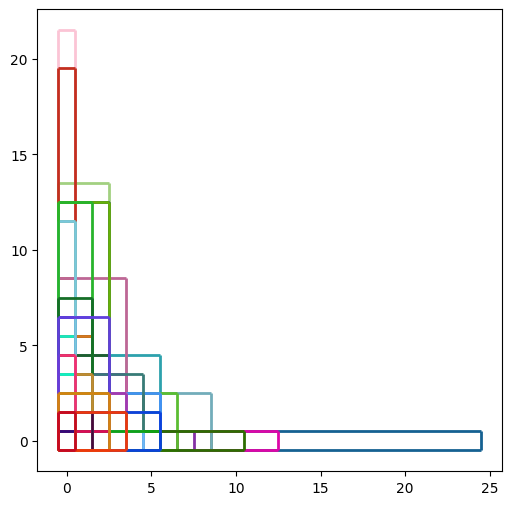

In [9]:
illustrate_truncation(truncation_OB)

In [10]:
def illustrate_truncationM(truncationM_dict):
    rng = np.random.default_rng()
    fig, axs = plt.subplots(figsize=(6, 6))
    for i, truncation in truncationM_dict.items():
        colour = list(rng.integers(0, 256, size=3))
        axs.hlines([truncation['minM_x1_OB'] - 0.5, truncation['maxM_x1_OB'] + 0.5], xmin=truncation['minM_x2_OB'] - 0.5, xmax=truncation['maxM_x2_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs.vlines([truncation['minM_x2_OB'] - 0.5, truncation['maxM_x2_OB'] + 0.5], ymin=truncation['minM_x1_OB'] - 0.5, ymax=truncation['maxM_x1_OB'] + 0.5, color=[colour, colour], linewidth=2)

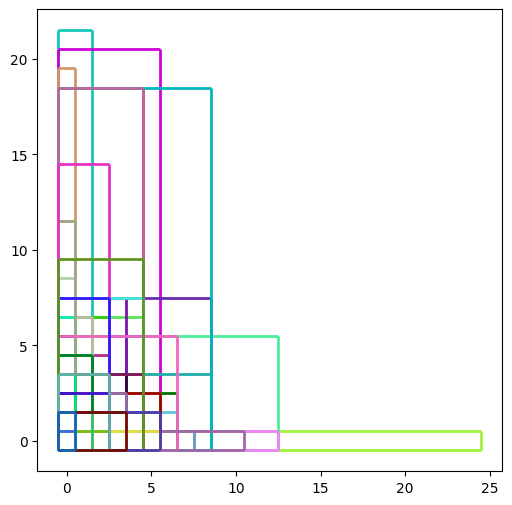

In [11]:
illustrate_truncationM(truncationM_OB)

# Truncation summary

Need to compute summary information about collection of OB truncations in the dataset for use when computing OG truncations and coefficients

Need:
- set of all observed state pairs $(x_{1}^{OB}, x_{2}^{OB})$ within any truncation
- set of all observed states $x^{OB}$ in either pair of any truncation

In [12]:
def summarise_truncation(truncation_OB, truncationM_OB):
    '''
    Summarise states included in collection of observed truncations
    '''

    # state set
    state_pairs = set()
    states = set()

    # loop over each truncation
    for i, trunc in truncation_OB.items():

        # for each state pair in truncation
        for x1_OB in range(trunc['min_x1_OB'], trunc['max_x1_OB'] + 1):
            for x2_OB in range(trunc['min_x2_OB'], trunc['max_x2_OB'] + 1):

                # add to set
                state_pairs.add((x1_OB, x2_OB))
                states.add(x1_OB)
                states.add(x2_OB)

    # also add any single states (not pairs) in marginal truncations that were missed
    for i, trunc in truncationM_OB.items():
        for x1_OB in range(trunc['minM_x1_OB'], trunc['maxM_x1_OB'] + 1):
            states.add(x1_OB)
        for x2_OB in range(trunc['minM_x2_OB'], trunc['maxM_x2_OB'] + 1):
            states.add(x2_OB)

    # collect info
    info_dict = {
        'state_pairs': state_pairs,
        'states': states
    }

    return info_dict

In [13]:
truncation_summary = summarise_truncation(truncation_OB, truncationM_OB)

# Original Truncation

For every state in OB truncation need to compute the (marginal approx of) original truncation interval and store in dict

## Marginal truncation function

Computes marginal approximation of truncation bounds for an observed state and capture efficiency vector

In [14]:
def Bm_trunc(x_OB, x_OG, beta):
    return np.mean(scipy.stats.binom.pmf(x_OB, x_OG, beta))

In [15]:
def marginal_truncation(x_OB, beta, threshM_OG=10**-6):

    # start at first non-zero coefficient
    x_OG = x_OB
    coeff = Bm_trunc(x_OB, x_OG, beta)

    # if not above threshold: increment until above
    while coeff < threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store first state coeff >= thresh
    minM_OG = x_OG

    # increment until below threshold
    while coeff >= threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store last state with coeff >= thresh (INCLUSIVE BOUND)
    maxM_OG = x_OG - 1

    return minM_OG, maxM_OG

In [16]:
def original_truncation(truncation_summary, beta):
    
    # collect OG truncations
    truncation_dict = {}

    # compute truncation for each observed count
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        minM_OG, maxM_OG = marginal_truncation(x_OB, beta)

        # store
        truncation_dict[x_OB] = (minM_OG, maxM_OG)

    return truncation_dict

In [17]:
truncation_OG = original_truncation(truncation_summary, beta)

100%|██████████| 25/25 [00:41<00:00,  1.66s/it]


# Coefficients

For every state in OB truncations need to compute grid of marginal coefficients (OG truncation x beta)

Then for every pair of states in OB truncations use marginal grids to compute and store outer products (B coefficient matrix)

In [18]:
def Bm_matrix(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta)

In [19]:
def compute_coefficients(truncation_summary, truncation_OG, beta, thresh_OG=10**-6):

    # store marginal grids
    marginal_grids = {}

    # loop over observed counts
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        # get truncation
        minM_OG, maxM_OG = truncation_OG[x_OB]

        # construct arrays for broadcasting
        x_OB_arr = np.array([x_OB])[:, None]
        x_OG_arr = np.arange(minM_OG, maxM_OG + 1)[:, None]
        beta_arr = beta[None, :]
          
        # compute marginal grid
        marginal_grid = Bm_matrix(x_OB_arr, x_OG_arr, beta_arr)

        # store
        marginal_grids[x_OB] = marginal_grid

        # take mean over beta to get marginal coefficient array
        marginal_array = np.mean(marginal_grid, axis=1)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x_OB}.npy",
            marginal_array
        )

    # loop over oberved count pairs
    for x1_OB, x2_OB in tqdm.tqdm(truncation_summary['state_pairs']):

        # get marginal grids
        grid_x1_OB = marginal_grids[x1_OB]
        grid_x2_OB = marginal_grids[x2_OB]

        # compute outer product
        coeff_grid = grid_x1_OB @ grid_x2_OB.T

        # threshold
        coeff_grid[coeff_grid < thresh_OG] = 0.0

        '''Have not divided by n here'''
        coeff_grid /= len(beta)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy",
            coeff_grid
        )

In [20]:
compute_coefficients(truncation_summary, truncation_OG, beta)

100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


# Per sample original truncation range

For CME constraints and variable sizes need to know the largest and smallest original counts in each sample's truncation

In [21]:
def compute_original_extent(truncation_OB, truncationM_OB, truncation_OG):

    # store per sample extent
    extent_dict = {}

    # for each sample
    for sample in truncation_OB.keys():

        # record min and max OG state extents
        min_x1_OG_ext, max_x1_OG_ext = np.inf, 0
        min_x2_OG_ext, max_x2_OG_ext = np.inf, 0

        # get OB truncation
        trunc_OB = truncation_OB[sample]

        # loop over OG truncation to get OG states used and update extent
        for x1_OB in range(trunc_OB['min_x1_OB'], trunc_OB['max_x1_OB'] + 1):
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            if min_x1_OG < min_x1_OG_ext:
                min_x1_OG_ext = min_x1_OG
            if max_x1_OG > max_x1_OG_ext:
                max_x1_OG_ext = max_x1_OG

        for x2_OB in range(trunc_OB['min_x2_OB'], trunc_OB['max_x2_OB'] + 1):
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            if min_x2_OG < min_x2_OG_ext:
                min_x2_OG_ext = min_x2_OG
            if max_x2_OG > max_x2_OG_ext:
                max_x2_OG_ext = max_x2_OG

        # get marginal OB truncation
        truncM_OB = truncationM_OB[sample]

        # repeat same process to update extent
        for x1_OB in range(truncM_OB['minM_x1_OB'], truncM_OB['maxM_x1_OB'] + 1):
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            if min_x1_OG < min_x1_OG_ext:
                min_x1_OG_ext = min_x1_OG
            if max_x1_OG > max_x1_OG_ext:
                max_x1_OG_ext = max_x1_OG

        for x2_OB in range(truncM_OB['minM_x2_OB'], truncM_OB['maxM_x2_OB'] + 1):
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            if min_x2_OG < min_x2_OG_ext:
                min_x2_OG_ext = min_x2_OG
            if max_x2_OG > max_x2_OG_ext:
                max_x2_OG_ext = max_x2_OG

        # store extent for the sample
        extent_dict[sample] = {
            'min_x1_OG': min_x1_OG_ext,
            'max_x1_OG': max_x1_OG_ext,
            'min_x2_OG': min_x2_OG_ext,
            'max_x2_OG': max_x2_OG_ext
        }

    return extent_dict

In [22]:
extent_OG = compute_original_extent(truncation_OB, truncationM_OB, truncation_OG)

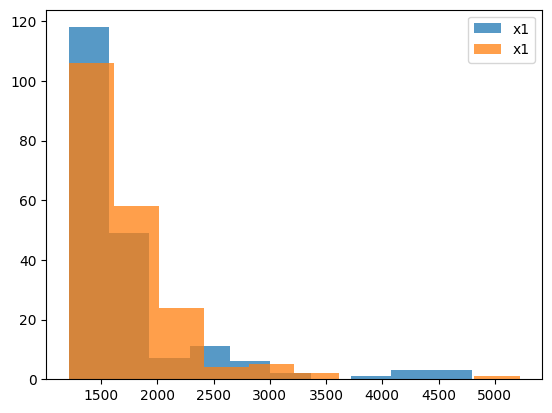

In [23]:
plt.hist([trunc_OG['max_x1_OG'] for trunc_OG in extent_OG.values()], alpha=0.75, label="x1")
plt.hist([trunc_OG['max_x2_OG'] for trunc_OG in extent_OG.values()], alpha=0.75, label="x1")
plt.legend()
plt.show()

# Construct constraints

## B constraints

Using OB truncation of the sample, OG truncation of each OB state pair and loading saved coefficient and bound arrays construct B matrix constraints and add to model

In [24]:
def add_B_constraints(model, variables, truncation_OB, truncation_OG, i):

    # get OB truncation for sample
    min_x1_OB = truncation_OB['min_x1_OB']
    max_x1_OB = truncation_OB['max_x1_OB']
    min_x2_OB = truncation_OB['min_x2_OB']
    max_x2_OB = truncation_OB['max_x2_OB']

    # load CI bounds for sample
    bounds = np.load(f"./Test-Info/Bounds/Joint/sample-{i}.npy")
            
    # for each OB state pair in truncation
    for x1_OB in range(min_x1_OB, max_x1_OB + 1):
        for x2_OB in range(min_x2_OB, max_x2_OB + 1):

            s = time()

            # get OG truncation for OB state pair
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            
            # load coefficient grid for OB state pair
            B_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy")

            # slice variables to truncation
            p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]
            p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

            # bilinear form
            sum_expr = p1_slice.T @ B_coeffs @ p2_slice
        
            # form constraints using CI bounds
            model.addConstr(sum_expr >= bounds[0, x1_OB, x2_OB], name=f"B_lb_{x1_OB}_{x2_OB}")
            model.addConstr(sum_expr <= bounds[1, x1_OB, x2_OB], name=f"B_ub_{x1_OB}_{x2_OB}")

            print(f"Constraint ({x1_OB}, {x2_OB}): {time() - s}")

## Marginal B constraints

In [25]:
def add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG, i):

    # get marginal OB truncation for sample
    minM_x1_OB = truncationM_OB['minM_x1_OB']
    maxM_x1_OB = truncationM_OB['maxM_x1_OB']
    minM_x2_OB = truncationM_OB['minM_x2_OB']
    maxM_x2_OB = truncationM_OB['maxM_x2_OB']

    # load CI bounds for sample
    x1_bounds = np.load(f"./Test-Info/Bounds/x1_marginal/sample-{i}.npy")
    x2_bounds = np.load(f"./Test-Info/Bounds/x2_marginal/sample-{i}.npy")

    # for each OB state in truncation
    for x1_OB in range(minM_x1_OB, maxM_x1_OB + 1):

        s = time()

        # get OG truncation
        min_x1_OG, max_x1_OG = truncation_OG[x1_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}.npy")

        # slice variable to truncation
        p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p1_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x1_bounds[0, x1_OB], name=f"Bm_x1_lb_{x1_OB}")
        model.addConstr(sum_expr <= x1_bounds[1, x1_OB], name=f"Bm_x1_ub_{x1_OB}")

        print(f"Constraint Bm({x1_OB}): {time() - s}")

    # repeat for x2
    for x2_OB in range(minM_x2_OB, maxM_x2_OB + 1):

        s = time()

        # get OG truncation
        min_x2_OG, max_x2_OG = truncation_OG[x2_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x2_OB}.npy")

        # slice variable to truncation
        p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p2_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x2_bounds[0, x2_OB], name=f"Bm_x2_lb_{x2_OB}")
        model.addConstr(sum_expr <= x2_bounds[1, x2_OB], name=f"Bm_x2_ub_{x2_OB}")

        print(f"Constraint Bm({x2_OB}): {time() - s}")

## CME constraints

Using OG extent, add CME constraints to the model

NOTE: matrix and mat experimental (i.e. don't work...)

In [26]:
def add_CME_constraints_matrix(model, variables, extent_OG, i):

    '''
    - could use outer product for p_dummy equality
    - could use Q matrix to combine CME constraints
    '''

    # get extent of OG states
    max_x1_OG = extent_OG[f'sample-{i}']['max_x1_OG']
    max_x2_OG = extent_OG[f'sample-{i}']['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    rates = variables['rates']
    z = variables['z']

    # construct ~rate matrix
    Q_mat = np.array([
        [0, rates['k_tx_1'], 0, 0],
        [rates['k_tx_2'], -(rates['k_tx_1'] + rates['k_tx_2']), -rates['k_deg_2'], rates['k_deg_2']],
        [0, -rates['k_deg_1'], 0, 0],
        [0, rates['k_deg_1'], 0, 0]
    ])

    # construct stacked arrays
    col_1 = gp.concatenate((z, p1[0:max_x1_OG - 1])).reshape(-1, 1)
    col_2 = p1[0:max_x1_OG].reshape(-1, 1)
    col_3 = p1[0:max_x1_OG].reshape(-1, 1)
    col_4 = p1[1: max_x1_OG + 1].reshape(-1, 1)
    stack_x1 = gp.hstack((col_1, col_2, col_3, col_4))

    # construct stacked coefficients
    col_1 = np.ones((max_x1_OG, 1))
    col_2 = np.ones((max_x1_OG, 1))
    col_3 = np.arange(max_x1_OG).reshape(-1, 1)
    col_4 = np.arange(1, max_x1_OG + 1).reshape(-1, 1)
    stack_coeff_x1 = np.hstack((col_1, col_2, col_3, col_4))

    '''
    # construct stacked arrays
    col_1 = gp.concatenate((z, p1[0:max_x2_OG - 1])).reshape(1, -1)
    col_2 = p1[0:max_x2_OG].reshape(1, -1)
    col_3 = np.arange(max_x2_OG).reshape(1, -1) * p1[0:max_x2_OG].reshape(1, -1)
    col_4 = np.arange(1, max_x2_OG + 1).reshape(1, -1) * p1[1: max_x2_OG + 1].reshape(1, -1)
    stack_x2 = gp.vstack((col_1, col_2, col_3, col_4))
    '''
    # construct stacked arrays
    col_1 = gp.concatenate((z, p1[0:max_x2_OG - 1])).reshape(1, -1)
    col_2 = p1[0:max_x2_OG].reshape(1, -1)
    col_3 = p1[0:max_x2_OG].reshape(1, -1)
    col_4 = p1[1: max_x2_OG + 1].reshape(1, -1)
    stack_x2 = gp.vstack((col_1, col_2, col_3, col_4))

    # construct stacked coefficients
    col_1 = np.ones((1, max_x2_OG))
    col_2 = np.ones((1, max_x2_OG))
    col_3 = np.arange(max_x2_OG).reshape(1, -1)
    col_4 = np.arange(1, max_x2_OG + 1).reshape(1, -1)
    stack_coeff_x2 = np.vstack((col_1, col_2, col_3, col_4))

    mat_x1 = model.addMVar(shape=(max_x1_OG, 4), vtype=GRB.CONTINUOUS, name="mat_x1", lb=0, ub=1)
    mat_x2 = model.addMVar(shape=(4, max_x2_OG), vtype=GRB.CONTINUOUS, name="mat_x2", lb=0, ub=1)
    
    model.addConstr(mat_x1 == stack_coeff_x1 * stack_x1)

    model.addConstr(mat_x2 == stack_coeff_x2 * stack_x2)

    print(type(mat_x1))
    print(type(Q_mat))
    
    prod = mat_x1 @ Q_mat

    prod_2 = prod @ mat_x2

    # add constraint
    # model.addConstr(stack_x1 @ Q @ stack_x2 == 0, name="CME")
    model.addConstr(prod_2 == 0, name="CME")

In [28]:
def add_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p = variables['p']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']
    
    # manually add x1_OG = x2_OG = 0 constraint (to avoid p(0) terms)
    model.addConstr(
        0 == k_deg_1 * p[1, 0] + \
        k_deg_2 * p[0, 1] - \
        (k_tx_1 + k_tx_2) * p[0, 0],
        name="CME_0_0"
    )

    # manually add x1_OG = 0 constraints (to avoid p1(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_2 * p[0, x2_OG - 1] + \
            k_deg_1 * p[1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[0, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_2 * x2_OG) * p[0, x2_OG]
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_0_x2"
    )
    # manually add x2_OG = 0 constraints (to avoid p2(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, 0] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, 0] + \
            k_deg_2 * p[x1_OG, 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG) * p[x1_OG, 0]
            for x1_OG in range(1, max_x1_OG)
        ),
        name="CME_x1_0"
    )

    # add CME constraints
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, x2_OG] + \
            k_tx_2 * p[x1_OG, x2_OG - 1] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[x1_OG, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG + k_deg_2 * x2_OG) * p[x1_OG, x2_OG]
            for x1_OG in range(1, max_x1_OG)
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_x1_x2"
    )

In [390]:
def add_CME_constraints_mat(model, variables, extent_OG, i):

    # get extent of OG states
    max_x1_OG = 100#extent_OG[f'sample-{i}']['max_x1_OG']
    max_x2_OG = 100#extent_OG[f'sample-{i}']['max_x2_OG']

    # get variables
    p = variables['p']
    k_tx_1 = variables['rates']['k_tx_1']
    k_tx_2 = variables['rates']['k_tx_2']
    k_deg_1 = variables['rates']['k_deg_2']
    k_deg_2 = variables['rates']['k_deg_1']

    # construct Q matrices
    Q_tx_1 = np.zeros((max_x1_OG + 1, max_x2_OG + 1, max_x1_OG + 1, max_x2_OG + 1))

    print(Q_tx_1.shape)
    print(p.shape)

    expr = Q_tx_1 * p[:, :, None, None]

    print(expr.shape)

    expr = expr.sum(axis=(2, 3))

    print(expr.shape)

    # add matrix constraints
    model.addConstr(
        k_tx_1 * expr == 0,
        name="CME"
    )

## Marginal CME constraints

In [29]:
def add_marginal_CME_constraints_gen(model, variables, extent_OG, i):

    # get extent of OG states
    max_x1_OG = extent_OG[f'sample-{i}']['max_x1_OG']
    max_x2_OG = extent_OG[f'sample-{i}']['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['rates']['k_tx_1']
    k_tx_2 = variables['rates']['k_tx_2']
    k_deg_1 = variables['rates']['k_deg_2']
    k_deg_2 = variables['rates']['k_deg_1']

    # manually add 1st constraints (to avoid p(-1) terms)
    model.addConstr(
        k_deg_1*p1[1] - k_tx_1*p1[0] == 0,
        name="Marginal_CME_x1_0"
    )
    model.addConstr(
        k_deg_2*p2[1] - k_tx_2*p2[0] == 0,
        name="Marginal_CME_x2_0"
    )

    # add constraints via generators
    model.addConstrs(
        (
            k_tx_1*p1[x1_OG - 1] + k_deg_1*(x1_OG + 1)*p1[x1_OG + 1] - (k_tx_1 + k_deg_1*x1_OG)*p1[x1_OG] == 0
            for x1_OG in range(1, max_x1_OG)
        ),
        name=f"Marginal_CME_x1"
    )
    
    model.addConstrs(
        (
            k_tx_2*p2[x2_OG - 1] + k_deg_2*(x2_OG + 1)*p2[x2_OG + 1] - (k_tx_2 + k_deg_2*x2_OG)*p2[x2_OG] == 0
            for x2_OG in range(1, max_x2_OG)
        ),
        name=f"Marginal_CME_x2"
    )

In [30]:
def add_marginal_CME_constraints_loop(model, variables, extent_OG, i):

    # get extent of OG states
    max_x1_OG = extent_OG[f'sample-{i}']['max_x1_OG']
    max_x2_OG = extent_OG[f'sample-{i}']['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['rates']['k_tx_1']
    k_tx_2 = variables['rates']['k_tx_2']
    k_deg_1 = variables['rates']['k_deg_2']
    k_deg_2 = variables['rates']['k_deg_1']

    # manually add 1st constraints (to avoid p(-1) terms)
    model.addConstr(
        k_deg_1*p1[1] - k_tx_1*p1[0] == 0,
        name="Marginal_CME_x1_0"
    )
    model.addConstr(
        k_deg_2*p2[1] - k_tx_2*p2[0] == 0,
        name="Marginal_CME_x2_0"
    )

    # loop to add constraints
    for x1_OG in range(1, max_x1_OG):

        model.addConstr(
            k_tx_1*p1[x1_OG - 1] + k_deg_1*(x1_OG + 1)*p1[x1_OG + 1] - (k_tx_1 + k_deg_1*x1_OG)*p1[x1_OG] == 0,
            name=f"Marginal_CME_x1_{x1_OG}"
        )
    
    for x2_OG in range(1, max_x2_OG):

        model.addConstr(
            k_tx_2*p2[x2_OG - 1] + k_deg_2*(x2_OG + 1)*p2[x2_OG + 1] - (k_tx_2 + k_deg_2*x2_OG)*p2[x2_OG] == 0,
            name=f"Marginal_CME_x2_{x2_OG}"
        )

In [31]:
def add_marginal_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']

    # construct Q matrices: 1 more column than square to add upper diagonal to last row
    Q_tx_1 = (np.diag([1 for x in range(1, max_x1_OG + 1)], -1) - np.diag([1 for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_tx_2 = (np.diag([1 for x in range(1, max_x2_OG + 1)], -1) - np.diag([1 for x in range(max_x2_OG + 1)]))[:-1, :]
    Q_deg_1 = (np.diag([x for x in range(1, max_x1_OG + 1)], 1) - np.diag([x for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_deg_2 = (np.diag([x for x in range(1, max_x2_OG + 1)], 1) - np.diag([x for x in range(max_x2_OG + 1)]))[:-1, :]

    # add matrix constraints
    model.addConstr(
        k_tx_1 * (Q_tx_1 @ p1) + k_deg_1 * (Q_deg_1 @ p1) == 0,
        name="Marginal_CME_x1"
    )

    model.addConstr(
        k_tx_2 * (Q_tx_2 @ p2) + k_deg_2 * (Q_deg_2 @ p2) == 0,
        name="Marginal_CME_x2"
    )

## Base Model

Construct a base model that includes only p, rate variables and CME constraints of a given size for a stochastic reaction network.

Will be saved to file to allow fast repeated loading to add sample specific B / moment constraints

In [32]:
def base_model(max_x1_OG, max_x2_OG, filepath=None, filetype="lp"):
    '''
    Construct and return base model containing large number of CME constraints
    and probability and rate variables needed.
    '''

    # default storage location
    if filepath is None:
        filepath = f"./Test-Info/Models/base_model_{max_x1_OG}_{max_x2_OG}.{filetype}"

    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('base-model', env=env) as model:

            # variables
            
            # joint variable to avoid triple products (not supported by GUROBI): should be removed by presolve
            p = model.addMVar(shape=(max_x1_OG + 1, max_x2_OG + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            K = 100
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # CME constraints

            # get variables
            k_tx_1 = rates['k_tx_1']
            k_tx_2 = rates['k_tx_2']
            k_deg_1 = rates['k_deg_2']
            k_deg_2 = rates['k_deg_1']
            
            # manually add x1_OG = x2_OG = 0 constraint (to avoid p(0) terms)
            model.addConstr(
                0 == k_deg_1 * p[1, 0] + \
                k_deg_2 * p[0, 1] - \
                (k_tx_1 + k_tx_2) * p[0, 0],
                name="CME_0_0"
            )

            # manually add x1_OG = 0 constraints (to avoid p1(-1) terms)
            model.addConstrs(
                (
                    0 == k_tx_2 * p[0, x2_OG - 1] + \
                    k_deg_1 * p[1, x2_OG] + \
                    k_deg_2 * (x2_OG + 1) * p[0, x2_OG + 1] - \
                    (k_tx_1 + k_tx_2 + k_deg_2 * x2_OG) * p[0, x2_OG]
                    for x2_OG in range(1, max_x2_OG)
                ),
                name="CME_0_x2"
            )
            # manually add x2_OG = 0 constraints (to avoid p2(-1) terms)
            model.addConstrs(
                (
                    0 == k_tx_1 * p[x1_OG - 1, 0] + \
                    k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, 0] + \
                    k_deg_2 * p[x1_OG, 1] - \
                    (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG) * p[x1_OG, 0]
                    for x1_OG in range(1, max_x1_OG)
                ),
                name="CME_x1_0"
            )

            # add CME constraints
            model.addConstrs(
                (
                    0 == k_tx_1 * p[x1_OG - 1, x2_OG] + \
                    k_tx_2 * p[x1_OG, x2_OG - 1] + \
                    k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
                    k_deg_2 * (x2_OG + 1) * p[x1_OG, x2_OG + 1] - \
                    (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG + k_deg_2 * x2_OG) * p[x1_OG, x2_OG]
                    for x1_OG in range(1, max_x1_OG)
                    for x2_OG in range(1, max_x2_OG)
                ),
                name="CME_x1_x2"
            )

            # write to file
            model.write(filepath)

In [545]:
base_model(2000, 2000)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Set parameter TimeLimit to value 300


In [548]:
base_model(1000, 1000)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Set parameter TimeLimit to value 300


In [ ]:
base_model(100, 100)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Set parameter TimeLimit to value 300


## Basic constraints

e.g. distributional constraints, fixed rates, factorization of p into p1 and p2, etc

In [33]:
def add_base_constraints(model, variables):

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    model.addConstr(variables['k_deg_1'] == 1, name="Fix_k_deg_1")
    model.addConstr(variables['k_deg_2'] == 1, name="Fix_k_deg_2")

    # distributional constraints
    model.addConstr(variables['p1'].sum() <= 1, name="Dist_x1")
    model.addConstr(variables['p2'].sum() <= 1, name="Dist_x2")

In [34]:
def add_factorization_constraint(model, variables):

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    p = variables['p']

    # outer product marginals
    outer = p1[:, None] @ p2[None, :]

    # equate dummy joint variable to product of marginals: all original states
    model.addConstr(p == outer, name=f"Joint_factorize")

# Model Setup

Use above functions to add constraints to a model, or to write a base model containing CME constraints.

## Load model

Given a base model filepath and sample information
- load the base model
- recover variable objects
- then can add new variables and call constraint functions before optimizing

## Construct model

Given only sample information
- setup a new model
- then can add new variables and call constraint functions before optimizing

e.g. if do not want to include full CME constraints or do not want overhead of file loading

## Code: Loading model

In [35]:
def load_variables(model, max_x1_OG, max_x2_OG):

    # get list of all variables
    variable_list = model.getVars()

    # setup lists for p variables
    p_list = [[None for x2 in range(max_x2_OG + 1)] for x1 in range(max_x1_OG + 1)]

    # setup variable dict
    variables = {}

    # sort p variables
    for var in variable_list:

        # get name
        name = var.VarName

        # store rates directly
        if "k" in name:
            variables[name] = var
            continue

        # extract index
        name_split = name[2:-1].split(",")
        x1 = int(name_split[0])
        x2 = int(name_split[1])

        # store (if within range specified)
        try:
            p_list[x1][x2] = var
        except IndexError:
            continue

    # construct p MVar
    p = gp.MVar.fromlist(p_list)

    # store
    variables['p'] = p

    # return variable dict
    return variables

In [36]:
def load_model(filepath, truncation_OB, truncationM_OB, truncation_OG, extent_OG):

    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # environment context
    with gp.Env(params=options) as env:

        # load base model
        model = gp.read(filepath, env=env)

        # load variables
        try:
            variables = load_variables(model, extent_OG['max_x1_OG'], extent_OG['max_x2_OG'])
        except ValueError:
            print("ERROR: Loaded model too small for sample OG extent")
            return None

        # display variable size
        print(variables['p'].shape)

        '''
        Can then add variables e.g. p1, p2
        and constraints via functions
        before optimizing
        '''

In [656]:
load_model(
    "./Test-Info/Models/base_model_2000_2000",
    truncation_OB['sample-0'],
    truncationM_OB['sample-0'],
    truncation_OG,
    extent_OG['sample-0']
)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Read LP format model from file ./Test-Info/Models/base_model_2000_2000.lp
Reading time = 511.44 seconds
: 0 rows, 4004005 columns, 0 nonzeros
GetVars 10.894054174423218
Mvar 30.502772092819214


In [708]:
load_model(
    "./Test-Info/Models/base_model_100_100",
    truncation_OB['sample-0'],
    truncationM_OB['sample-0'],
    truncation_OG,
    {'min_x1_OG': 0, 'max_x1_OG': 100, 'min_x2_OG': 0, 'max_x2_OG': 100} #extent_OG['sample-0']
)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Read LP format model from file ./Test-Info/Models/base_model_100_100.lp
Reading time = 0.10 seconds
: 0 rows, 10205 columns, 0 nonzeros
(101, 101)


## Code: constructing model

In [37]:
def construct_model(truncation_OB, truncationM_OB, truncation_OG, extent_OG):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            '''
            Now add variables e.g. p1, p2
            and constraints via functions
            before optimizing

            e.g.
            '''

            # model settings
            model.Params.TimeLimit = 300
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # collect variables
            variables = {
                'p': p,
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2']
            }

            # constraints

            # base constraints
            # add_base_constraints(model, variables)

            # independence constraints
            # add_factorization_constraint(model, variables, extent_OG)

            # B constraints
            # add_B_constraints(model, variables, truncation_OB, truncation_OG)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG)

            # CME constraints
            # add_CME_constraints(model, variables, extent_OG)

            # marginal CME constraints
            # add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize
            # model.setObjective(0, GRB.MINIMIZE)
            # model.optimize()
            # print(f"Model is {status_codes[model.status]}")

In [720]:
construct_model(
    truncation_OB['sample-0'],
    truncationM_OB['sample-0'],
    truncation_OG,
    extent_OG['sample-0']
)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret


Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Set parameter TimeLimit to value 300


# Model filetype comparison

Compare writing and loading times for .lp and .mps filetypes

In [ ]:
# re-run below for 1000 x 1000 models

In [47]:
# write base model to .lp file
base_model(1000, 1000, filetype="lp")

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk


In [48]:
# write base model to .mps file
base_model(1000, 1000, filetype="mps")

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk


In [49]:
# load .lp model file
load_model(
    "./Test-Info/Models/base_model_1000_1000.lp",
    truncation_OB['sample-0'],
    truncationM_OB['sample-0'],
    truncation_OG,
    extent_OG['sample-0']
)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Read LP format model from file ./Test-Info/Models/base_model_1000_1000.lp
Reading time = 8.47 seconds
: 0 rows, 1002005 columns, 0 nonzeros
ERROR: Loaded model too small for sample OG extent


In [50]:
# load .mps model file
load_model(
    "./Test-Info/Models/base_model_1000_1000.mps",
    truncation_OB['sample-0'],
    truncationM_OB['sample-0'],
    truncation_OG,
    extent_OG['sample-0']
)

Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Read MPS format model from file ./Test-Info/Models/base_model_1000_1000.mps
Reading time = 9.70 seconds
base-model: 0 rows, 1002005 columns, 0 nonzeros
ERROR: Loaded model too small for sample OG extent


# LaTeX CME

Joint probabilities

\begin{align*}
0 &= k_{{tx}_{1}} p(x_{1} - 1, x_{2}) \\
&+ k_{{tx}_{2}} p(x_{1}, x_{2} - 1) \\
&+ k_{{deg}_{1}} (x_{1} + 1) p(x_{1} + 1, x_{2}) \\
&+ k_{{deg}_{2}} (x_{2} + 1) p(x_{1}, x_{2} + 1) \\
&- (k_{{tx}_{1}} + k_{{tx}_2} + k_{{deg}_{1}} x_{1} + k_{{deg}_{2}} x_{2}) p(x_{1}, x_{2})
\end{align*}

Independence assumption: factorise into marginals

\begin{align*}
0 &= k_{{tx}_{1}} p_{1}(x_{1} - 1) p_{2}(x_{2}) \\
&+ k_{{tx}_{2}} p_{1}(x_{1}) p_{2}(x_{2} - 1) \\
&+ k_{{deg}_{1}} (x_{1} + 1) p_{1}(x_{1} + 1) p_{2}(x_{2}) \\
&+ k_{{deg}_{2}} (x_{2} + 1) p_{1}(x_{1}) p_{2}(x_{2} + 1) \\
&- (k_{{tx}_{1}} + k_{{tx}_2} + k_{{deg}_{1}} x_{1} + k_{{deg}_{2}} x_{2}) p_{1}(x_{1}) p_{2}(x_{2})
\end{align*}